# Analysing Reviews of Star Wars: The Last Jedi

Here I'll be running an analysis of Star Wars: The Last Jedi reviews.

In [1]:
import numpy as np
import pandas as pd

import nltk
import spacy
import textacy

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
% matplotlib inline

In [2]:
nlp = spacy.load('en')

In [4]:
review_data = pd.read_csv("../rotten_tomatoes/reviews.csv")
review_data = review_data.drop_duplicates()

In [5]:
review_data.head()

,date,review,star_rating,name
0,"December 24, 2017",One start only because of the special effects.,1.0,Ed F
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N


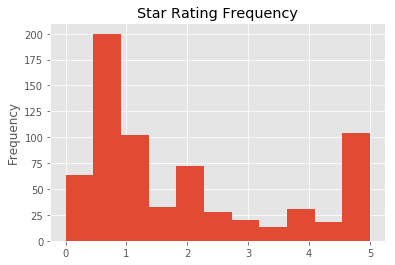

In [6]:
(review_data.star_rating
    .plot(kind = 'hist', bins = 11, title = 'Star Rating Frequency'))

In [7]:
review_data.head(10)

,date,review,star_rating,name
0,"December 24, 2017",One start only because of the special effects.,1.0,Ed F
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N
5,"December 24, 2017",TLJ presents a riveting follow-up to TFA. It's...,4.5,Henry K
6,"December 24, 2017",This movie sticks with you but for the wrong r...,0.5,Pierre B
7,"December 24, 2017",This film was a film that didn't have to be ma...,2.5,Alfredo L
8,"December 24, 2017",A bloated mess of a film that is too long and ...,0.0,Sneed C
9,"December 24, 2017",Difficult to know where to start with this mes...,1.5,Darren S


# Box Office Data

In [28]:
import re

In [15]:
opening_data = pd.read_csv("../data/box_office_opening.csv", encoding = 'ansi')

In [32]:
opening_data['Opening'] = opening_data.Opening.apply(lambda s: float(re.sub("\$|,", "", s)))

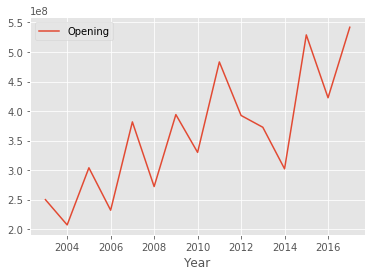

In [33]:
(opening_data.groupby('Year')['Opening']
     .max()
     .reset_index()
     .plot(kind = 'line', x = 'Year', y = "Opening"))

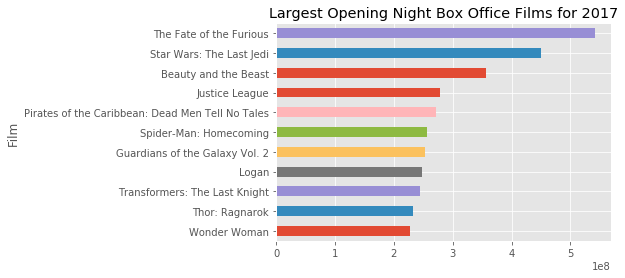

In [44]:
(opening_data[opening_data.Year == 2017]
     .sort_values("Opening")
     .plot(kind = 'barh', x = 'Film', y = 'Opening', legend = False,
           title = "Largest Opening Night Box Office Films for 2017")
)

## Gender Matching

Let's have a go at detecting gender in the names dataset, this way we can see if there's any gender bias in the data.

In [7]:
from nltk.corpus import names

# get names by gender from nltk corpus
names = ([(name, 'male') for name in names.words('male.txt')] + \
         [(name, 'female') for name in names.words('female.txt')])

# create dataframe of name data
name_data = pd.DataFrame(names, columns = ['name', 'sex'])
name_data.name = name_data.name.str.lower()

# disaggregate into male/female categories
name_data['male']   = name_data.sex == 'male'
name_data['female'] = name_data.sex == 'female'
name_data = name_data[['name', 'male', 'female']]

# deduplicate name column for cases where names are acceptable as male or female
name_data = (name_data
    .groupby('name')[['male', 'female']]
    .sum()
    .reset_index())

# calculate name length
name_data['length'] = name_data.name.apply(len)

# perform train-test-validation split
name_data['train_test_validation'] = np.random.choice(['train', 'test', 'validation'], 
                                                      size = len(name_data), p = [0.7, 0.2, 0.1])
name_data['train'] = name_data.train_test_validation == "train"
name_data['test'] = name_data.train_test_validation == "test"
name_data['validation'] = name_data.train_test_validation == "validation"

train_data = name_data[name_data.train][['name', 'male', 'female', 'length']]

def male_or_female(x):
    """
    If x is male and female, return 'both', otherwise return 'male' 
    if x is male and return 'female' otherwise"""
    if x.male == 1:
        if x.female != 1:
            return 'male'
        else:
            return 'both'
    elif x.female == 1:
        return 'female'
    else:
        return 'both'

name_data['sex']  =  name_data[['male', 'female']].apply(male_or_female, axis = 1)
train_data['sex'] = train_data[['male', 'female']].apply(male_or_female, axis = 1)

# display a random sample of 10 names
(train_data.sample(10)
     .sort_values('name'))

,name,male,female,length,sex
578,audrey,0.0,1.0,6,female
938,brenna,0.0,1.0,6,female
2324,ernesta,0.0,1.0,7,female
2788,giancarlo,1.0,0.0,9,male
3467,janot,0.0,1.0,5,female
6005,robbie,1.0,1.0,6,both
6225,salli,0.0,1.0,5,female
6998,tootsie,0.0,1.0,7,female
7062,trudy,0.0,1.0,5,female
7566,zora,0.0,1.0,4,female


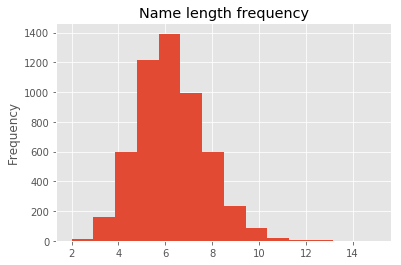

In [8]:
train_data.length.plot(kind = 'hist', bins = 14, title = 'Name length frequency')

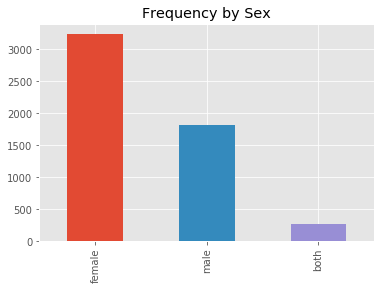

In [9]:
(train_data.sex
     .value_counts()
     .plot(kind = 'bar', title = 'Frequency by Sex'))

The gender distribution is quite uneven. We will have to modify it before we train the model so that we don't have any issues later.

In [10]:
sample_size = np.int32(
    np.sum(train_data.sex == 'female') - \
    np.sum(train_data.sex == 'male') + \
    0.5 * np.sum(train_data.sex == 'both'))

train_data = pd.concat([train_data[train_data.male == 1]
     .sample(sample_size, replace = True)
     .reset_index(drop = True),
     train_data])

That's should have fixed it - the number of male and female names in the dataset should be about equal now.

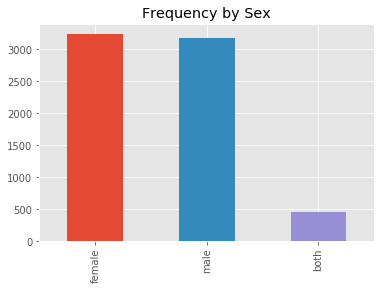

In [11]:
(train_data.sex
     .value_counts()
     .plot(kind = 'bar', title = 'Frequency by Sex'))

sex
both      AxesSubplot(0.125,0.125;0.775x0.755)
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

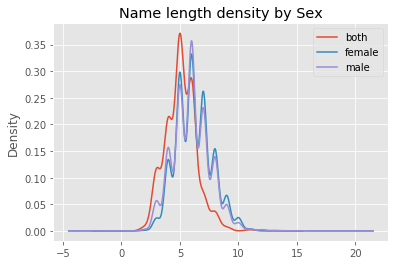

In [12]:
(train_data.groupby('sex')['length']
     .plot(kind = 'density', title = "Name length density by Sex", legend = True))

We now append columns to `name_data` containing features for the name classifier we wish to train.

In [13]:
def add_name_features(data):
    """Add features to dataset"""
    # Useful features for gender classification by name
    data['last_letter']         = data.name.apply(lambda s: s[-1 ])
    data['last_two_letters']    = data.name.apply(lambda s: s[-2:])
    data['last_three_letters']  = data.name.apply(lambda s: s[-3:])
    data['first_letter']        = data.name.apply(lambda s: s[0 ])
    data['first_two_letters']   = data.name.apply(lambda s: s[:2])
    data['first_three_letters'] = data.name.apply(lambda s: s[:3])

    return data

train_data = add_name_features(train_data)
name_data  = add_name_features(name_data)

train_data.head()

,name,male,female,length,sex,last_letter,last_two_letters,last_three_letters,first_letter,first_two_letters,first_three_letters
0,neale,1.0,0.0,5,male,e,le,ale,n,ne,nea
1,tamas,1.0,0.0,5,male,s,as,mas,t,ta,tam
2,archy,1.0,0.0,5,male,y,hy,chy,a,ar,arc
3,rodrick,1.0,0.0,7,male,k,ck,ick,r,ro,rod
4,judah,1.0,0.0,5,male,h,ah,dah,j,ju,jud


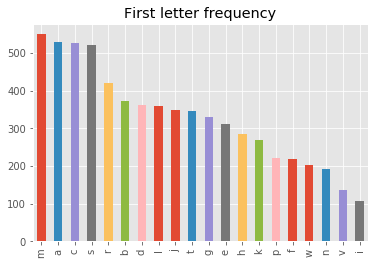

In [14]:
(train_data.first_letter
     .value_counts()
     .head(20)
     .plot(kind = 'bar', title = 'First letter frequency'))

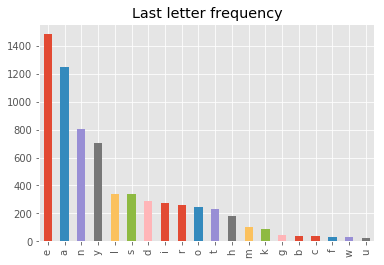

In [15]:
(train_data.last_letter
     .value_counts()
     .head(20)
     .plot(kind = 'bar', title = 'Last letter frequency'))

## Using Scikit-Learn

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
cv = CountVectorizer(strip_accents = 'unicode', analyzer = 'char_wb',
                     ngram_range = (1, 4), max_features = None,
                     preprocessor = lambda s: ''.join(['^', s, '$']))

In [18]:
cv.fit(train_data.name)

CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4),
        preprocessor=<function <lambda> at 0x000001855B580EA0>,
        stop_words=None, strip_accents='unicode',
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [19]:
X = cv.transform(train_data.name)
X.shape

(6862, 13058)

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
clf = RandomForestClassifier(max_features = 5,
    n_estimators = 500, random_state = 0, n_jobs = -1)
clf.fit(X, train_data[['male', 'female']])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
X_test = cv.transform(name_data[name_data.test].name)

In [23]:
X.shape, X_test.shape

((6862, 13058), (1505, 13058))

In [24]:
y_train = clf.predict(X)
y_test  = clf.predict(X_test)

In [25]:
# Calculate Test Accuracy
np.sum(y_test == name_data[name_data.test][['male', 'female']]) /\
    np.sum(name_data.test)

male      0.881063
female    0.889037
dtype: float64

In [26]:
X = cv.transform(name_data.name)
y_pred_all = clf.predict(X)

In [27]:
name_data['male_pred']   = y_pred_all[:, 0]
name_data['female_pred'] = y_pred_all[:, 1]

We take a moment to look at the male names which have been misclassified:

In [28]:
print(', '.join(name_data[name_data.test & (name_data.male != name_data.male_pred)]['name'].unique()))

addis, adlai, alexis, alison, alley, allison, andrea, antonie, arne, aubrie, aubry, augusta, aurie, avrit, bari, bertie, bev, bobbie, brandy, bren, cain, carmine, carroll, carsten, cary, chandal, chevalier, christian, clary, clemence, cleo, clovis, cobbie, cody, con, corry, courtenay, cybal, daffie, dane, dani, dannye, darcy, darrell, dawn, dayle, demeter, denny, devan, dorry, dyan, ebony, eimile, eli, elias, elijah, em, emyle, etienne, eustace, everett, ezra, fanchon, felice, felipe, filip, filipe, gates, georgiamay, giovanne, giovanni, greer, guthrie, guy, haily, hatty, hedvig, hephzibah, honey, inger, irvine, jaime, jean, jemimah, jodi, jodie, joel, joey, jordain, jorey, jorry, judith, kalil, kane, kareem, karl, kaspar, kendre, keren, kerrill, kevyn, kip, korney, kristian, kym, lindsay, lindy, linn, linoel, lorne, lust, marietta, martie, marylou, meade, mendie, meredithe, merl, mersey, mildred, min, mischa, morgen, nate, neil, nert, noah, noe, noel, odell, olive, olwen, oral, ossie,

Here are the female names that the algorithm thought were for females

In [29]:
print(', '.join(name_data[name_data.test & (name_data.female != name_data.female_pred)]['name'].unique()))

adlai, adnan, alison, alley, allison, angus, ariel, arne, ashish, aubry, austin, bari, bary, bev, bren, brett, cain, caldwell, carlo, carsten, chaddie, chane, chevalier, christ, christiano, clark, clem, clemence, cleo, cobbie, con, dane, darrell, davis, demeter, demetri, devan, devin, doyle, drake, dustin, dyan, eimile, eli, elias, elijah, em, ernie, esau, etienne, eustace, evan, everett, ezra, fabian, fanchon, fazeel, felipe, filip, filipe, gallagher, gates, giovanne, giovanni, gordie, guthrey, guthrie, guy, haily, haleigh, hazel, hedvig, hephzibah, hymie, iggie, irvine, javier, jemimah, jeramie, jessey, jeth, joann, joaquin, joel, johann, jorry, julio, kalil, kane, kareem, karl, kaspar, kendre, kevyn, kristian, laurens, leigh, len, lincoln, linoel, lion, lonny, lust, lyle, mace, mart, maurice, maxim, meir, mendel, mendie, merril, michale, mildred, mischa, nate, neddie, neil, noah, noe, odell, olwen, oral, oran, ossie, ozzie, pen, piper, quinn, quintin, rae, raphael, raven, reece, rod

In [30]:
def get_sex_pred(x):
    """
    If x is male and female, return 'both', otherwise return 'male' 
    if x is male and return 'female' otherwise"""
    if x.male_pred == 1:
        if x.female_pred != 1:
            return 'male'
        else:
            return 'both'
    elif x.female_pred == 1:
        return 'female'
    else:
        return 'both'

In [31]:
name_data['sex_pred']  =  name_data[['male_pred', 'female_pred']]\
    .apply(get_sex_pred, axis = 1)

And here are all of the names that while being used for both males and females, was not predicted as such.

In [32]:
name_data[(name_data.test & (name_data.sex == 'both')) & (name_data.sex_pred != 'both')].name.unique()

array(['alexis', 'andrea', 'ariel', 'austin', 'bertie', 'bobbie', 'brandy',
       'brett', 'carmine', 'carroll', 'cary', 'christian', 'clem', 'cody',
       'dani', 'darcy', 'denny', 'devin', 'felice', 'haleigh', 'hazel',
       'jaime', 'jean', 'joann', 'jodi', 'jodie', 'joey', 'judith', 'kip',
       'leigh', 'lindsay', 'lindy', 'lorne', 'marietta', 'martie', 'meade',
       'noel', 'pen', 'quinn', 'randie', 'robin', 'shell', 'stacy',
       'sunny', 'tally', 'tammie', 'valentine', 'vin', 'vinnie'], dtype=object)

Now the model is trained, I can use it to perform the classification on the names from rotten tomatoes.

In [33]:
X = cv.transform(review_data.name.apply(lambda s: s.strip().split(" ")[0]))
y_pred = clf.predict(X)

review_data['male']   = y_pred[:, 0]
review_data['female'] = y_pred[:, 1]

review_data['sex'] = review_data.apply(male_or_female, axis = 1)

In [34]:
review_data.head()

,date,review,star_rating,name,male,female,sex
0,"December 24, 2017",One start only because of the special effects.,1.0,Ed F,1.0,0.0,male
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R,1.0,0.0,male
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A,1.0,0.0,male
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M,1.0,1.0,both
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N,1.0,0.0,male


What I'll do here is produce some predictions, and then perform a manual review so I don't have to individually inspect each of the names in the dataset.

In [35]:
unique_names = pd.DataFrame(sorted(review_data.name.apply(lambda s: s.strip().lower().split(" ")[0]).unique()), columns = ['first_name'])
X = cv.transform(unique_names.first_name)
y_pred = clf.predict(X)
unique_names['male']   = y_pred[:, 0]
unique_names['female'] = y_pred[:, 1]
unique_names['sex'] = unique_names.apply(male_or_female, axis = 1)

In [36]:
unique_names.head()

,first_name,male,female,sex
0,,1.0,1.0,both
1,?ukasz,1.0,0.0,male
2,a,0.0,1.0,female
3,aaron,1.0,0.0,male
4,abdallah,1.0,0.0,male


In [37]:
unique_names.to_csv('../data/unique_names.csv', index = None)

I have manually reviewed the dataset, and have named the new file `unique_names_reviewed.csv`. I can now load the reviewed dataset to retrieve the improved values, and use this to perform my gender analysis of the reviews.

In [38]:
unique_names_reviewed = pd.read_csv("../data/unique_names_reviewed.csv", na_values = '')
unique_names_reviewed.head()

,first_name,male,female,sex
0,NaN,1,1,both
1,?ukasz,1,0,male
2,a,0,1,female
3,aaron,1,0,male
4,abdallah,1,0,male


In [39]:
(unique_names.merge(unique_names_reviewed, on = 'first_name', how = 'left')
    .to_csv("../data/unique_names.csv"))

In [41]:
review_data['first_name'] = (review_data.name
     .apply(lambda s: s.strip().lower().split(" ")[0]))
review_data = review_data[['date', 'review', 'star_rating', 'name', 'first_name']].merge(unique_names_reviewed, how='left', on = 'first_name')

In [42]:
review_data.head()

,date,review,star_rating,name,first_name,male,female,sex
0,"December 24, 2017",One start only because of the special effects.,1.0,Ed F,ed,1.0,0.0,male
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R,hals,1.0,0.0,male
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A,ian,1.0,0.0,male
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M,m,1.0,0.0,male
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N,james,1.0,0.0,male


In [43]:
review_data

,date,review,star_rating,name,first_name,male,female,sex
0,"December 24, 2017",One start only because of the special effects.,1.0,Ed F,ed,1.0,0.0,male
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R,hals,1.0,0.0,male
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A,ian,1.0,0.0,male
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M,m,1.0,0.0,male
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N,james,1.0,0.0,male
5,"December 24, 2017",TLJ presents a riveting follow-up to TFA. It's...,4.5,Henry K,henry,1.0,0.0,male
6,"December 24, 2017",This movie sticks with you but for the wrong r...,0.5,Pierre B,pierre,1.0,0.0,male
7,"December 24, 2017",This film was a film that didn't have to be ma...,2.5,Alfredo L,alfredo,1.0,0.0,male
8,"December 24, 2017",A bloated mess of a film that is too long and ...,0.0,Sneed C,sneed,1.0,0.0,male
9,"December 24, 2017",Difficult to know where to start with this mes...,1.5,Darren S,darren,1.0,0.0,male


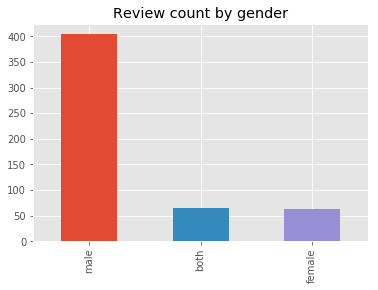

In [44]:
(review_data.sex
     .value_counts()
     .plot(kind = 'bar', title = 'Review count by gender')
)

sex
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: star_rating, dtype: object

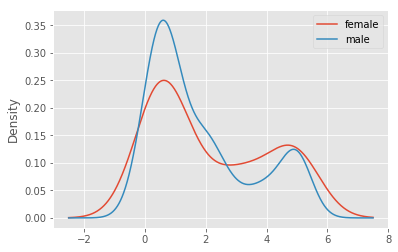

In [45]:
(review_data[review_data.sex != 'both']
    .groupby('sex')['star_rating']
    .plot(kind = 'density', legend = True))

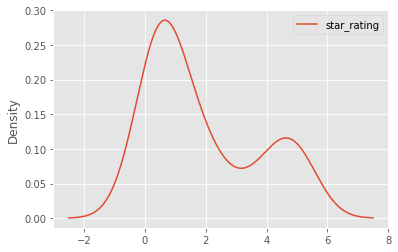

In [46]:
(review_data[review_data.sex == 'both']
    ['star_rating']
    .plot(kind = 'density', legend = True))

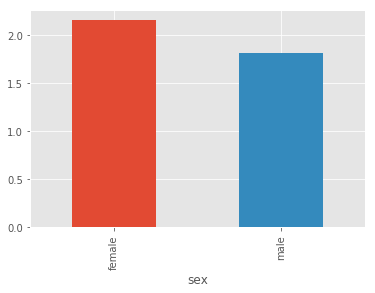

In [47]:
(review_data[review_data.sex != 'both']
    .groupby('sex')['star_rating']
    .mean()
    .plot(kind = 'bar'))

There is gender bias - females enjoy the film more than males.

Is it possible to quantify the certainty around this measurement?

In [48]:
review_data[review_data.female == 1]

,date,review,star_rating,name,first_name,male,female,sex
22,"December 24, 2017",Poorly written and poorly acted.,0.5,Alex S,alex,1.0,1.0,both
24,"December 24, 2017",Did not answer or address any story line arcs ...,0.0,Tracy S,tracy,1.0,1.0,both
29,"December 24, 2017","I'm not an alt-right, fanboy, or Trump support...",0.5,Boooooo T,boooooo,1.0,1.0,both
31,"December 24, 2017",It is the worst Star Wars movie of all the saga.,0.5,tahseen n,tahseen,0.0,1.0,female
34,"December 24, 2017",Saw Star Wars - The Last Jedi today. It was ok...,3.5,Cathie L,cathie,0.0,1.0,female
44,"December 24, 2017","Incoherent facts, characters, motivations. \n\...",0.5,Maxime B,maxime,0.0,1.0,female
59,"December 24, 2017",The Last Jedi was seriously too much. There ar...,0.5,Ashley G,ashley,0.0,1.0,female
62,"December 24, 2017",Thank you Mr.Johnson that you destroyed a whol...,0.5,Val S,val,1.0,1.0,both
65,"December 24, 2017",On est habituÃ (C) Ã beaucoup plus d'action. ...,3.5,Marc-André B,marc-andré,0.0,1.0,female
70,"December 24, 2017",This should summarize the billiance of this mo...,0.5,Anirudh V,anirudh,0.0,1.0,female


## Exploring the Review Content

Here I'll use `scikit-learn` to do some feature selection. We should be able to find some simple correlations between positive and negative terms in the dataset.

In [49]:
review_data['length'] = review_data.review.apply(len)

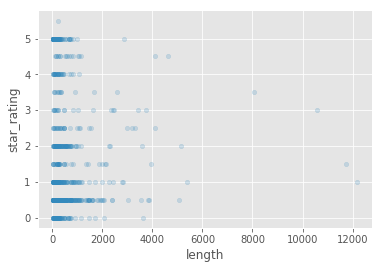

In [50]:
(review_data
    .plot(x = 'length', y = 'star_rating', kind = 'scatter', alpha = 0.2))

### The longest review

In [51]:
print(review_data.loc[review_data.length == review_data.length.max(), 'review'].values[0])

Bad movie, bad star wars movie... this movie grabbed the idiot ball and held on. Sorry this is going to be hate filled.

Ok so now we are confirmed that the Republic fell like a rotting house when the door was kicked in.

The Poe and Hux dialogue while funny doesn't belong in the movie unless your creating a Saturday morning cartoon. Also do dreadnoughts not have shields, and why would you have bombers that physically need to drop something... in Space!!! Why not torpedo bombers like Y-Wings or B-Wings. Also why are the rest of the Star Destroyers just sitting their jacking off. Seriously that was the most anti-climatic space battle ever. Seriously I cannot get over how stupid the bombers were, seriously who would ever design something like that for SPACE combat.

Moving from the opening stupidity we know the First Order is weeks away from conquering every important system in the galaxy, but was afraid of a Fleet orbiting what... 5 systems? How big is the Order supposed to be to be wor

The new trilogy, or at least the first two movies, are not good stories.


In [52]:
print(review_data.loc[(review_data.length >= 4624) & (review_data.star_rating > 4), 'review'].values[0])

!!!SPOILERS ALERT!!!

This is a different Star Wars. A Star Wars I'm not familiar with. But at the same time, it's a Star Wars I like a lot. It's really hard to say whether TLJ is better than the others or not (we do know the answer when it comes to the prequels) since it is different. So let's talk about the things I liked about TLJ.

TLJ had a lot of humor and there was a little bit of darkness in it as well. It wasn't that dark as I expected but it did had some dark elements in it. The humor in this movie was incredible. It had me every time. The movie it self was beautifully shot. I liked the scenes in the island a lot! They were in my opinion quite deep. The action in this movie was good as well. Really good! (Puppet) Yoda was in it (that was the expectation that seemed to be true) as well and I loved that. Okay, maybe he didn't look that great but it was still enormously pleasing to see our old little green and wise friend. Rey had some conversations with Kylo by using the force 

Now onto the scikit-learn stuff:

In [53]:
review_data['train_test_validation'] = np.random.choice(['train', 'test', 'validation'], 
                                                      size = len(review_data), p = [0.7, 0.2, 0.1])
review_data['train']      = review_data.train_test_validation == "train"
review_data['test']       = review_data.train_test_validation == "test"
review_data['validation'] = review_data.train_test_validation == "validation"

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from nltk.corpus import stopwords

In [64]:
tfidf = TfidfVectorizer(
    strip_accents = 'unicode', 
    stop_words=stopwords.words('english'),
    ngram_range = (1, 4))

cv = CountVectorizer(
    strip_accents = 'unicode', 
    stop_words=stopwords.words('english'),
    ngram_range = (1, 4))

cv.fit(review_data.loc[review_data.train, 'review'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [65]:
X_train = tfidf.fit_transform(review_data.loc[review_data.train, 'review'])

In [66]:
X_test = tfidf.transform(review_data[review_data.test].review)

In [67]:
rfc = RandomForestRegressor(max_features = 5,
    n_estimators = 500, random_state = 0, n_jobs = -1,
    )
rfc.fit(X_train, review_data[review_data.train].star_rating)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [68]:
review_data['star_rating_pred'] = rfc.predict(tfidf.transform(review_data.review))

In [69]:
rfc.score(X_test, review_data[review_data.test].star_rating)

0.2222358434168219

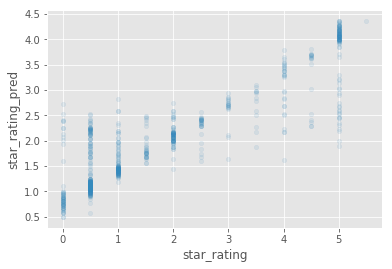

In [70]:
review_data.plot(x = 'star_rating', y = 'star_rating_pred', kind = 'scatter', alpha = 0.1)

In [71]:
feature_data = pd.DataFrame(list(tfidf.get_feature_names()), columns = ['vocab'])
feature_data['importance'] = rfc.feature_importances_
feature_data['tf_idf'] = np.array(X_test.sum(axis = 0))[0,:]
feature_data['term_count'] =  np.array(np.sum(cv.transform(review_data.loc[review_data.test, 'review']), axis = 0))[0, :]
feature_data['doc_count'] =  np.array(np.sum(cv.transform(review_data.loc[review_data.test, 'review']) > 0, axis = 0))[0, :]
feature_data = feature_data.sort_values('importance', ascending = False)
feature_data.head(10)

,vocab,importance,tf_idf,term_count,doc_count
40794,loved,0.006384,1.478460,16,14
45007,movie,0.004188,7.075488,187,80
6141,best,0.003470,1.306852,13,13
29375,great,0.002996,2.777753,31,26
6233,best star,0.002852,0.846495,3,3
29503,great movie,0.002330,0.752667,4,4
66085,star wars,0.002296,6.355212,142,73
6234,best star wars,0.002226,0.846495,3,3
65992,star,0.002174,6.575984,151,75
40827,loved movie,0.001952,0.185137,1,1


In [72]:
len(feature_data)

80622

In [73]:
np.array(np.any((cv.transform(review_data.loc[review_data.test, 'review']) > 0).todense(), axis = 0))

array([[ True, False, False, ..., False, False, False]], dtype=bool)

In [74]:
review_data

,date,review,star_rating,name,first_name,male,female,sex,length,train_test_validation,train,test,validation,star_rating_pred
0,"December 24, 2017",One start only because of the special effects.,1.0,Ed F,ed,1.0,0.0,male,46,train,True,False,False,1.512500
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R,hals,1.0,0.0,male,762,train,True,False,False,1.071000
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A,ian,1.0,0.0,male,361,train,True,False,False,3.379000
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M,m,1.0,0.0,male,101,train,True,False,False,1.393000
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N,james,1.0,0.0,male,560,test,False,True,False,2.251000
5,"December 24, 2017",TLJ presents a riveting follow-up to TFA. It's...,4.5,Henry K,henry,1.0,0.0,male,739,test,False,True,False,2.408000
6,"December 24, 2017",This movie sticks with you but for the wrong r...,0.5,Pierre B,pierre,1.0,0.0,male,1011,test,False,True,False,1.673000
7,"December 24, 2017",This film was a film that didn't have to be ma...,2.5,Alfredo L,alfredo,1.0,0.0,male,484,train,True,False,False,2.411000
8,"December 24, 2017",A bloated mess of a film that is too long and ...,0.0,Sneed C,sneed,1.0,0.0,male,255,train,True,False,False,0.731000
9,"December 24, 2017",Difficult to know where to start with this mes...,1.5,Darren S,darren,1.0,0.0,male,1346,train,True,False,False,1.556000


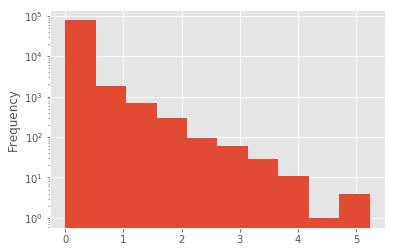

In [75]:
feature_data.term_count.apply(np.log1p).plot(kind = 'hist', logy = True)

In [76]:
X_test

<135x80622 sparse matrix of type '<class 'numpy.float64'>'
	with 7265 stored elements in Compressed Sparse Row format>

In [77]:
review_data[review_data.review.str.contains("movie")]

,date,review,star_rating,name,first_name,male,female,sex,length,train_test_validation,train,test,validation,star_rating_pred
1,"December 24, 2017",When I heard Disney had purchased Star Wars so...,0.5,Hals R,hals,1.0,0.0,male,762,train,True,False,False,1.071000
2,"December 24, 2017","""Just breathe"" and go see it a second time. En...",4.0,Ian A,ian,1.0,0.0,male,361,train,True,False,False,3.379000
3,"December 24, 2017","If you need to keep checking your watch, the m...",1.0,M M,m,1.0,0.0,male,101,train,True,False,False,1.393000
4,"December 24, 2017",Just hated it. Wanted this movie to make some ...,0.5,James N,james,1.0,0.0,male,560,test,False,True,False,2.251000
6,"December 24, 2017",This movie sticks with you but for the wrong r...,0.5,Pierre B,pierre,1.0,0.0,male,1011,test,False,True,False,1.673000
7,"December 24, 2017",This film was a film that didn't have to be ma...,2.5,Alfredo L,alfredo,1.0,0.0,male,484,train,True,False,False,2.411000
9,"December 24, 2017",Difficult to know where to start with this mes...,1.5,Darren S,darren,1.0,0.0,male,1346,train,True,False,False,1.556000
10,"December 24, 2017","A post modernist take on Star Wars, which make...",0.5,Churbology J,churbology,1.0,0.0,male,1638,train,True,False,False,1.075000
11,"December 24, 2017",Disappointed. A soulless movie. I've lost hope...,2.0,,,NaN,NaN,NaN,50,train,True,False,False,2.108000
12,"December 24, 2017","Is it just me, or do a bunch of the 5 star rev...",1.5,Michael B,michael,1.0,0.0,male,314,test,False,True,False,2.283000


In [78]:
X_test

<135x80622 sparse matrix of type '<class 'numpy.float64'>'
	with 7265 stored elements in Compressed Sparse Row format>

In [79]:
X_test.todense() 

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [81]:
feature_data[feature_data.vocab.str.contains("kylo")].head()

,vocab,importance,tf_idf,term_count,doc_count
46473,movie wanted kylo,0.000111,0.000000,0,0
58492,rey poe kylo overall,0.000097,0.000000,0,0
76066,wanted kylo ren switch,0.000093,0.000000,0,0
36500,kylo overall,0.000092,0.000000,0,0
36509,kylo ren,0.000085,0.821692,10,9


I want to be able to select out a term and get a measure of it's 'effect' on the star rating.

In [82]:
len(review_data) - len(review_data.drop_duplicates())

0

In [83]:
[m for m in dir(nltk) if not m.startswith("_") and 'bayes' in m.lower()]

['NaiveBayesClassifier',
 'NaiveBayesDependencyScorer',
 'PositiveNaiveBayesClassifier',
 'naivebayes',
 'positivenaivebayes']

In [84]:
tfidf.get_feature_names()

['10',
 '10 10',
 '10 2nd',
 '10 2nd viewing',
 '10 2nd viewing much',
 '10 enough',
 '10 enough porg',
 '10 enough porg edit',
 '10 feel',
 '10 feel like',
 '10 feel like done',
 '10 force',
 '10 force awakens',
 '10 force awakens 10',
 '10 little',
 '10 little answered',
 '10 little answered film',
 '10 min',
 '10 min jedi',
 '10 min jedi training',
 '10 minutes',
 '10 minutes actual',
 '10 minutes actual plot',
 '10 rating',
 '10 rating thing',
 '10 rating thing good',
 '10 rogue',
 '10 rogue one',
 '10 rogue one 10',
 '10 times',
 '10 times watching',
 '10 times watching travesty',
 '100',
 '100 million',
 '100 million cookies',
 '100 million cookies one',
 '100 right',
 '100 right really',
 '100 right really understand',
 '1000x',
 '1000x soundtrack',
 '1000x soundtrack like',
 '1000x soundtrack like dessert',
 '100ish',
 '100ish members',
 '100ish members left',
 '100ish members left threw',
 '10min',
 '10min best',
 '11',
 '11 light',
 '11 light speed',
 '11 light speed weapon',